In [1]:
import sys
sys.path.insert(0, '../util')

from layer import *
from plot import *

from __future__ import division
import random
import math
import numpy as np
import pandas as pd
import time
from numpy.linalg import norm

xy = np.mgrid[-1:1:25j, -1:1:25j].reshape(2,-1).T
p = numpy.random.permutation(len(xy))
xy = xy[p]
xyT = xy.T

rastrigin = np.array(list(map(lambda x: ((x[0]**2 - 10 * np.cos(2 * np.pi * x[0]))+(x[1]**2 - 10 * np.cos(2 * np.pi * x[1])) + 20), xy))).reshape(1,-1)
objective_function = rastrigin

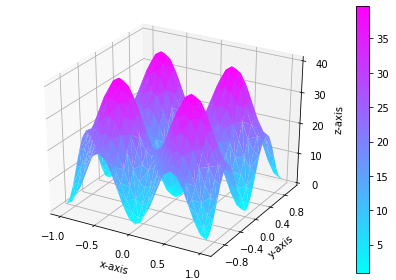

In [2]:
plot_output(xy,objective_function, "rastrigin-original")

In [3]:
input_size = 2
computational_layer = 30
output_layer = 1
dimensions = calculate_dimensions(input_size, computational_layer, output_layer)
print(dimensions)

def position_check(new_position):
    return np.clip(new_position,Wildebeest.pmin,Wildebeest.pmax)

class Wildebeest:
    global dimensions
    global_best_position = np.random.random((dimensions,))
    global_best_cost, _ = forward_pass_weights_reg(global_best_position,xyT,objective_function,input_size,computational_layer,output_layer)
    pmax = 10
    pmin = -10
    
    def __init__(self, dimensions):
        self.position = np.random.random((dimensions,))
        self.cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
        self.dimensions = dimensions
        self.velocity = np.random.random((dimensions,))
        self.pmax = 10
        self.pmin = -10
        
        self.alpha_1 = 0.9 #Local movement
        self.beta_1 = 0.3  #Local movement
        self.alpha_2 = 0.2 #Global movement
        self.beta_2 = 0.8  #Global movement
        
        self.delta_w = float(dimensions/8.0) #Threshold for nearness
        self.delta_c = 2 #Threshold for avoiding crowds
        
        self.learning_rate = 0.3
        self.n_steps = 6
        self.n_e = 4

    def take_steps(self):
        best_cost = self.cost
        best_position = self.position
        for _ in range(self.n_steps):
            new_random_velocity = -1.0 + 2.0*np.random.random((self.dimensions,));
            new_random_position = position_check(self.position + random.random()*new_random_velocity/norm(new_random_velocity))
            new_cost, _ = forward_pass_weights_reg(new_random_position,xyT,objective_function,input_size,computational_layer,output_layer)
            if(new_cost<best_cost):
                best_cost = new_cost
                best_position = new_random_position
        return best_position
    
    def update_position(self, new_position):
        self.position = position_check(self.alpha_1 * new_position + self.beta_1 * (self.position - new_position))
        self.cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
        
        if(self.cost < Wildebeest.global_best_cost):
            Wildebeest.global_best_position = self.position
            Wildebeest.global_best_cost = self.cost
        
    def herd_instinct(self, random_wildebeest):
        if(random_wildebeest.cost < self.cost and random.random() < 0.4):
            self.position = position_check(self.alpha_2 * self.position + self.beta_2 * random_wildebeest.position)
            self.cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
            
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost

    def feed_information(self, worst_position): #Starvation avoidance and Social Memory 

        if(norm(self.position-worst_position) < self.delta_w):
            new_random_velocity = -1 + 2*np.random.random((self.dimensions,));
            self.position = position_check(self.position + random.random()*10*(self.pmax-self.pmin)*new_random_velocity/norm(new_random_velocity))
            self.cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost
        
        if(norm(Wildebeest.global_best_position - self.position) < self.delta_c and norm(Wildebeest.global_best_position - self.position) > 1):
            self.position = position_check(Wildebeest.global_best_position + 0.0001*np.random.random((self.dimensions,)))
            self.cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
            if(self.cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = self.position
                Wildebeest.global_best_cost = self.cost
        
        for _ in range(self.n_e):
            velocity = -1 + 2*np.random.random((self.dimensions,))
            position = position_check(Wildebeest.global_best_position + 0.1 * (velocity/norm(velocity)))
            cost, _ = forward_pass_weights_reg(self.position,xyT,objective_function,input_size,computational_layer,output_layer)
            
            if(cost < Wildebeest.global_best_cost):
                Wildebeest.global_best_position = position
                Wildebeest.global_best_cost = cost


121


In [4]:
n_iterations = 200
n_population = 120

agents = [Wildebeest(dimensions = dimensions) for x in range(n_population)]
temp = []
cost_list = []

In [5]:
#Driver Code

start = time.time()
for _ in range(n_iterations):

    ##### Local Movement
    for agent in agents:
        new_position = agent.take_steps()
        agent.update_position(new_position)
    #####
    
    #### Herd Instinct 
    for agent in agents:
        h = random.randint(1,n_population) #Select random wildebeest instance
        random_agent = agents[h-1]
        agent.herd_instinct(random_agent)
    ######
    
    ### Get the worst solution out of the bunch for starvation avoidance
    for agent in agents:
        temp.append([agent.position,agent.cost])
    worst_position = sorted(temp, key = lambda x: x[1])[-1][0]
    ##########

    ### Apply Starvation avoidance and Social Memory
    for agent in agents:
        agent.feed_information(worst_position)
    ########
    
    cost_list.append(Wildebeest.global_best_cost)


    print(_)
end = time.time()
print(end-start)

cost, output = forward_pass_weights_reg(Wildebeest.global_best_position,xyT,objective_function,input_size, computational_layer, output_layer)
print(cost)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
798.3132948875427
119.79838478506841


In [6]:
print(reg_cost(objective_function, output))
print(mae(objective_function, output))

119.79838478506841
8.978601072352207


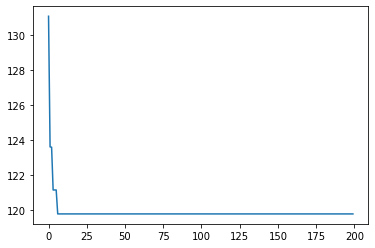

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(n_iterations), y = cost_list)

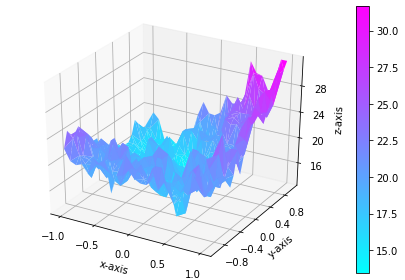

In [8]:
plot_output(xy, output, "Rastrigin-WHO")